In [9]:
import torch.nn.functional as F
from utilities3 import *
from timeit import default_timer



In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


In [4]:
class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv2d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv2d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x


In [5]:
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=64, y=64, c=12)
        output: the solution of the next timestep
        output shape: (batchsize, x=64, y=64, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 8 # pad the domain if input is non-periodic

        self.p = nn.Linear(12, self.width) # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.norm = nn.InstanceNorm2d(self.width)
        self.q = MLP(self.width, 1, self.width * 4) # output channel is 1: u(x, y)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.p(x)
        x = x.permute(0, 3, 1, 2)
        # x = F.pad(x, [0,self.padding, 0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.norm(self.conv0(self.norm(x)))
        x1 = self.mlp0(x1)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.norm(self.conv1(self.norm(x)))
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.norm(self.conv2(self.norm(x)))
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.norm(self.conv3(self.norm(x)))
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2

        # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic
        x = self.q(x)
        x = x.permute(0, 2, 3, 1)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [6]:
TRAIN_PATH = 'data/ns_data.mat'
TEST_PATH = 'data/ns_data_V1e-4_N20_T50_R256test.mat'

ntrain = 20
ntest = 20

modes = 12
width = 20

batch_size = 20
learning_rate = 0.001
epochs = 500
iterations = epochs*(ntrain//batch_size)

path = 'ns_fourier_2d_time_N'+str(ntrain)+'_ep' + str(epochs) + '_m' + str(modes) + '_w' + str(width)
path_model = 'model/'+path
path_train_err = 'results/'+path+'train.txt'
path_test_err = 'results/'+path+'test.txt'
path_image = 'image/'+path

sub = 1
S = 256
S1 = 64
T_in = 10
T = 10 # T=40 for V1e-3; T=20 for V1e-4; T=10 for V1e-5;
step = 1

In [7]:
reader = MatReader(TRAIN_PATH)
train_a = reader.read_field('u')[:ntrain,::sub,::sub,:T_in]
train_u = reader.read_field('u')[:ntrain,::sub,::sub,T_in:T+T_in]

reader = MatReader(TEST_PATH)
test_a = reader.read_field('u')[-ntest:,::sub,::sub,:T_in]
test_u = reader.read_field('u')[-ntest:,::sub,::sub,T_in:T+T_in]

print(train_u.shape)
print(test_u.shape)
assert (S1 == train_u.shape[-2])
assert (T == train_u.shape[-1])

train_a = train_a.reshape(ntrain,S1,S1,T_in)
test_a = test_a.reshape(ntest,S,S,T_in)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

torch.Size([20, 64, 64, 10])
torch.Size([20, 256, 256, 10])


In [ ]:
model = FNO2d(modes, modes, width).cpu()
print(count_params(model))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iterations)

myloss = LpLoss(size_average=False)
for ep in range(10):
    model.train()
    t1 = default_timer()
    train_l2_step = 0
    train_l2_full = 0
    
    print(ep, t1)
    for xx, yy in train_loader:
        loss = 0
        xx = xx.to(device)
        yy = yy.to(device)

        for t in range(0, T, step):
            y = yy[..., t:t + step]
            im = model(xx)
            loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))

            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), -1)

            xx = torch.cat((xx[..., step:], im), dim=-1)

        train_l2_step += loss.item()
        l2_full = myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1))
        train_l2_full += l2_full.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    test_l2_step = 0
    test_l2_full = 0
    with torch.no_grad():
        for xx, yy in test_loader:
            loss = 0
            xx = xx.to(device)
            yy = yy.to(device)

            for t in range(0, T, step):
                y = yy[..., t:t + step]
                im = model(xx)
                loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))

                if t == 0:
                    pred = im
                else:
                    pred = torch.cat((pred, im), -1)

                xx = torch.cat((xx[..., step:], im), dim=-1)

            test_l2_step += loss.item()
            test_l2_full += myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1)).item()

    t2 = default_timer()

928661
0 41810.174639832


In [35]:
print(ep, t2 - t1, train_l2_step / ntrain / (T / step), train_l2_full / ntrain, test_l2_step / ntest / (T / step),
          test_l2_full / ntest)

9 31.752363274001254 0.26198638916015626 0.2645571708679199 0.5428667449951172 0.5434823989868164


In [36]:
#test_samples = test_loader.dataset

import numpy as np

#np.shape(test_samples)
#test_samples[10,0]

test_loaders = {20: test_loader}
test_samples = test_loaders[20].dataset
test_samples[0,:,:,0][1]


tensor([[0.2983, 0.3035, 0.3083,  ..., 0.2810, 0.2871, 0.2928],
        [0.3097, 0.3151, 0.3201,  ..., 0.2916, 0.2980, 0.3040],
        [0.3207, 0.3263, 0.3316,  ..., 0.3016, 0.3084, 0.3147],
        ...,
        [0.2619, 0.2670, 0.2718,  ..., 0.2458, 0.2513, 0.2567],
        [0.2744, 0.2794, 0.2842,  ..., 0.2580, 0.2637, 0.2692],
        [0.2865, 0.2916, 0.2963,  ..., 0.2698, 0.2756, 0.2812]])

/tmp/ipykernel_8449/1434674431.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


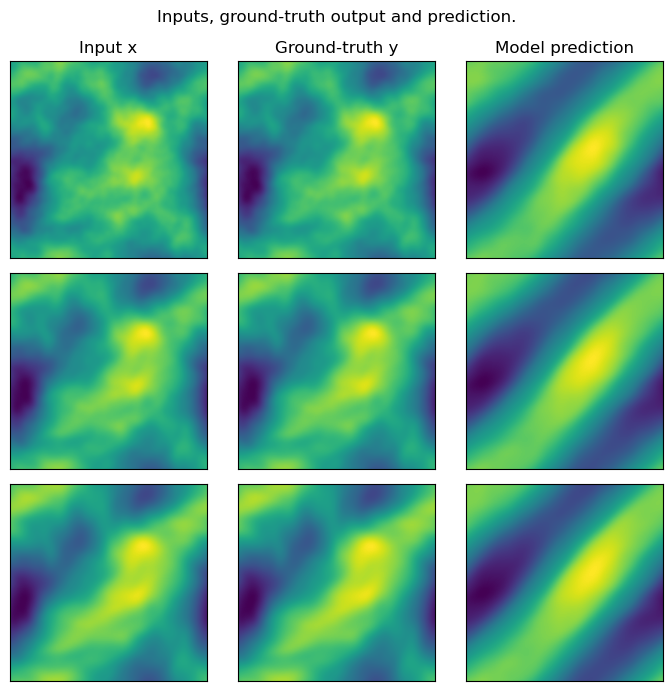

In [40]:


import matplotlib.pyplot as plt
rows = 3
fig = plt.figure(figsize=(7, 7))
for index in range(rows):
    data = test_samples[0,:,:,3*index][0]
    data1 = test_samples[0,:,:,3*index+1][0]
    out = pred[0,:,:,3*index]

    # Input x
    x = data
    # Ground-truth
    y = data1
    # Model prediction
    #out = model(xx)

    ax = fig.add_subplot(rows, 3, index*3 + 1)
    ax.imshow(x)
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(rows, 3, index*3 + 2)
    ax.imshow(y)
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(rows, 3, index*3 + 3)
    ax.imshow(out)
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()